Separate subcellular space into three distinct regions (innermost being nucleus) and calculates transcripts in each. 

In [1]:
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [3]:
drpath = '/stanley/WangLab/Connie/02.TEMPOmap/02.revisionCardiomyocyte64Gene/output'
apath = '/stanley/WangLab/Data/Processed/2022-09-30-Rena-Cardiomyocyte64Gene/output'
adata = sc.read_h5ad(os.path.join(apath, '2022-10-22-Rena-Cardiac64Gene-raw.h5ad'))
genes = adata.var.index
area_list = list(range(1,7))
# area2sample = {
#     1: 'STARmap',
#     2: '2h pulse 6h chase', 
#     3: '2h pulse 4h chase',
#     4: '20h pulse',
#     5: '2h pulse 0h chase',
#     6: '2h pulse 2h chase'
# }
area2sample = {
    1: 'STARmap',
    2: '2h_labeling_6h_wash', 
    3: '2h_labeling_4h_wash',
    4: '20h_labeling',
    5: '2h_labeling',
    6: '2h_labeling_2h_wash'
}

In [4]:
adata

AnnData object with n_obs × n_vars = 9629 × 64
    obs: 'orig_index', 'sample', 'area', 'x', 'y', 'z', 'nuclues_volume', 'AF546', 'AF546_nucleus', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts'
    layers: 'nucleus'

In [5]:
# import cell_meta (filtered by Haowen)
cell_meta = pd.read_csv('/stanley/WangLab/Connie/02.TEMPOmap/02.revisionCardiomyocyte64Gene/Nov10_cardiac_cluster_label.csv')
cell_meta

,Unnamed: 0,orig_index,sample,area,x,y,z,nuclues_volume,AF546,AF546_nucleus,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,volume,n_volume,nCount_RNA,nFeature_RNA,RNA_snn_res.0.1,seurat_clusters
0,1051,0,2h_labeling_6h_wash,505671,96,12726,17,295630,2,1,22,3.135494,105,4.663439,505671,295630,105,22,0,0
1,1052,1,2h_labeling_6h_wash,307387,54,7831,17,101313,0,0,18,2.944439,77,4.356709,307387,101313,77,18,0,0
2,1053,2,2h_labeling_6h_wash,133770,50,8461,15,91892,1,1,10,2.397895,17,2.890372,133770,91892,17,10,1,1
3,1054,3,2h_labeling_6h_wash,617687,133,1382,16,125781,5,0,25,3.258097,55,4.025352,617687,125781,55,25,1,1
4,1055,4,2h_labeling_6h_wash,275230,75,14348,14,89334,0,0,12,2.564949,52,3.970292,275230,89334,52,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8466,9624,1384,2h_labeling_2h_wash,658458,20239,7082,14,233127,1,0,24,3.218876,170,5.141664,658458,233127,170,24,0,0
8467,9625,1385,2h_labeling_2h_wash,318836,20220,9478,9,128602,2,2,27,3.332205,98,4.595120,318836,128602,98,27,0,0
8468,9626,1386,2h_labeling_2h_wash,639378,20277,11077,12,127610,0,0,31,3.465736,142,4.962845,639378,127610,142,31,0,0
8469,9627,1387,2h_labeling_2h_wash,345181,20281,12452,11,142509,2,0,37,3.637586,138,4.934474,345181,142509,138,37,0,0


In [6]:
# calculate dr_by_sample (each gene has one averaged DR per sample)
mean_by_sample = []
stdev_by_sample = []
for area in area_list:
    _adata = adata[adata.obs['sample']==area]
    dr = np.load(os.path.join(drpath, f'DR_area{area}.npy'), allow_pickle=True)
    midd = np.zeros(dr.shape)
    peri = np.zeros(dr.shape) 
    for i in range(dr.shape[0]):
        for j in range(dr.shape[1]):
            if type(dr[i,j]) == list:
                midd[i,j] = np.count_nonzero(np.array(dr[i,j])<0.909)
                peri[i,j] = np.count_nonzero(np.array(dr[i,j])>=0.909) 
    # _adata.layers['mid'] = midd
    # _adata.layers['peri'] = peri
    nuclsum = np.sum(_adata.layers['nucleus'], axis=1)
    middsum = np.sum(midd, axis=1)
    perisum = np.sum(peri, axis=1)
    # filter
    if area2sample[area] != 'STARmap':
        _cell_meta = cell_meta[cell_meta['sample']==area2sample[area]]
        flt = np.isin(_adata.obs['orig_index'], _cell_meta['orig_index'])
        nuclsum = nuclsum[flt]
        middsum = middsum[flt]
        perisum = perisum[flt]

    region_sum = np.array(list(zip(nuclsum, middsum, perisum)), dtype=int)
    region_sum = np.array([row/sum(row) for row in region_sum])
    region_mean = np.mean(region_sum, axis=0)
    region_stdev = np.std(region_sum, axis=0)
    mean_by_sample.append(region_mean)
    stdev_by_sample.append(region_stdev)

In [7]:
df_mean_by_sample = pd.DataFrame(mean_by_sample, columns=['nucl', 'midd', 'peri'])
df_stdev_by_sample = pd.DataFrame(stdev_by_sample, columns=['nucl', 'midd', 'peri'])
df_mean_by_sample['sample'] = area2sample.values()
df_stdev_by_sample['sample'] = area2sample.values()
df_mean_by_sample

,nucl,midd,peri,sample
0,0.218492,0.371936,0.409571,STARmap
1,0.381610,0.360404,0.257987,2h_labeling_6h_wash
2,0.378619,0.344756,0.276626,2h_labeling_4h_wash
3,0.408137,0.304973,0.286890,20h_labeling
4,0.601569,0.223224,0.175207,2h_labeling
5,0.443369,0.277640,0.278990,2h_labeling_2h_wash


In [23]:
# reorder sample list
sample_order = [5, 3, 2, 4, 0, 1]
df_mean_by_sample['order'] = sample_order
df_mean_by_sample.sort_values(by='order', inplace=True)
df_stdev_by_sample['order'] = sample_order
df_stdev_by_sample.sort_values(by='order', inplace=True)
df_stdev_by_sample

,nucl,midd,peri,sample,order
4,0.154584,0.124668,0.124449,2h_labeling,0
5,0.154709,0.148125,0.169387,2h_labeling_2h_wash,1
2,0.157209,0.148633,0.167945,2h_labeling_4h_wash,2
1,0.156939,0.149708,0.163543,2h_labeling_6h_wash,3
3,0.157758,0.142996,0.168720,20h_labeling,4
0,0.110443,0.180244,0.209737,STARmap,5


(([0, 1, 2, 3, 4, 5],
  [Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, ''),
   Text(0, 0, '')]),
 <matplotlib.legend.Legend at 0x2b24760c8190>)

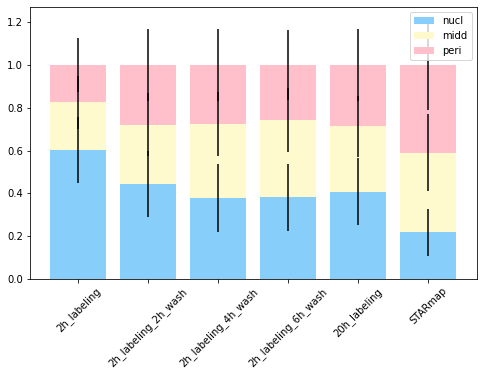

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(df_mean_by_sample['sample'], df_mean_by_sample['nucl'], yerr=df_stdev_by_sample['nucl'], label='nucl', color='lightskyblue')
ax.bar(df_mean_by_sample['sample'], df_mean_by_sample['midd'], yerr=df_stdev_by_sample['midd'], bottom=df_mean_by_sample['nucl'], label='midd', color='lemonchiffon')
ax.bar(df_mean_by_sample['sample'], df_mean_by_sample['peri'], yerr=df_stdev_by_sample['peri'], bottom=np.sum((df_mean_by_sample['nucl'], df_mean_by_sample['midd']), axis=0), label='peri', color='pink')
plt.xticks(rotation=45), plt.legend()

### separate by cell type

In [2]:
celltype = {
    0: 'cardiomyocyte',
    1: 'fibroblast'
}